In [1]:
!pip install ops

In [2]:
!pip install --upgrade keras


In [3]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras import ops, layers


SEED = 999
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [4]:
num_classes = 2
input_shape = (128, 128, 3)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
learning_rate = 0.001 #0.0001
weight_decay = 0.0001
batch_size = 16
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 128  # We'll resize input images to this size
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    1024,
    512,
]  # Size of the dense layers of the final classifier

In [7]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/0')
train_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/1')

val_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/0')
val_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/1')

test_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/0')
test_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/1')


# look-up table
classes = {0: 'non-glaucoma', 1: 'glaucoma'}


train_df = pd.concat([pd.DataFrame({ 'image' : train_data_0, 'label': 0 }),
                      pd.DataFrame({ 'image' : train_data_1, 'label': 1 }) ], ignore_index = True)


val_df = pd.concat([pd.DataFrame({ 'image' : val_data_0, 'label': 0 }),
                    pd.DataFrame({ 'image' : val_data_1, 'label': 1 }) ], ignore_index = True)


test_df = pd.concat([pd.DataFrame({ 'image' : test_data_0, 'label': 0 }),
                     pd.DataFrame({ 'image' : test_data_1, 'label': 1 }) ], ignore_index = True)


# train_df = shuffle(train_df, random_state = SEED).reset_index(drop = True)
# val_df = shuffle(val_df, random_state = SEED).reset_index(drop = True)
# test_df = shuffle(test_df, random_state = SEED).reset_index(drop = True)

# Seleccionar solo una tercera parte de los datos
# train_df = train_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)
# val_df = val_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)
# test_df = test_df.sample(frac=1/3, random_state=SEED).reset_index(drop=True)


print("train images -> ", train_df.shape[0])
print("val images -> ", val_df.shape[0])
print("test images -> ", test_df.shape[0])



train images ->  8631
val images ->  5767
test images ->  2250


In [8]:
def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label']))
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.batch(batch_size)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label']))
test_dataset = test_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image'], val_df['label']))
val_dataset = val_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.batch(batch_size)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

In [24]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [25]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images, sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1], padding='VALID')
        patches = tf.reshape(patches, [batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [26]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [27]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [28]:
modelo = create_vit_classifier()
modelo.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_2 (Patches)       │ (None, 16, 3072)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_2           │ (None, 16, 32)         │         98,848 │ patches_2[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, 16, 32)         │             64 │ patch_encoder_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 16, 32)         │         16,800 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 16, 32)         │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_27    │ (None, 16, 32)         │             64 │ add_24[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 16, 64)         │          2,112 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_43 (Dropout)      │ (None, 16, 64)         │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 16, 32)         │          2,080 │ dropout_43[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_44 (Dropout)      │ (None, 16, 32)         │              0 │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 16, 32)         │              0 │ dropout_44[0][0],      │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_28    │ (None, 16, 32)         │             64 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 16, 32)         │         16,800 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 16, 32)         │              0 │ multi_head_attention_… │
│                      

 Total params: 1,319,010 (5.03 MB)

 Trainable params: 1,319,010 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

modelo.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
)

my_callback = [keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)]

# Entrenar el modelo (se asume que train_dataset y val_dataset están definidos previamente)
history = modelo.fit(train_dataset, epochs=num_epochs, batch_size=batch_size,
                     validation_data=val_dataset, validation_batch_size=batch_size,
                     callbacks=my_callback)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 2457s 4s/step - accuracy: 0.9911 - loss: 0.0390 - val_accuracy: 0.3846 - val_loss: 108.3314
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 187s 342ms/step - accuracy: 0.9715 - loss: 3.4831 - val_accuracy: 0.3846 - val_loss: 256.1783
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 141s 262ms/step - accuracy: 0.9531 - loss: 10.7297 - val_accuracy: 0.3846 - val_loss: 156.5183
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 187s 346ms/step - accuracy: 0.9522 - loss: 6.6163 - val_accuracy: 0.3846 - val_loss: 21.3865
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 158s 265ms/step - accuracy: 0.9533 - loss: 0.7988 - val_accuracy: 0.3846 - val_loss: 32.3750
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 141s 260ms/step - accuracy: 0.9469 - loss: 1.4082 - val_accuracy: 0.3846 - val_loss: 25.9048
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.9394 - loss: 1.3276 - val_accuracy: 0.3846 - val_loss: 17.4581
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 204s 268ms/step - accuracy:

In [30]:
from tensorflow.keras.models import save_model

# Supongamos que 'model' es tu modelo ViT
modelo.save('/content/drive/My Drive/Tesis/Proyectos2/modelos/modelo_VIT_completonuevo10epocas.h5')


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Evaluación en el conjunto de validación
val_metrics = modelo.evaluate(val_dataset, verbose=0)
val_loss = val_metrics[0]
val_acc = val_metrics[1]

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Evaluación en el conjunto de prueba
test_metrics = modelo.evaluate(test_dataset, verbose=0)
test_loss = test_metrics[0]
test_acc = test_metrics[1]

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Predicciones en el conjunto de validación
val_predictions = modelo.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Predicciones en el conjunto de prueba
test_predictions = modelo.predict(test_dataset)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Calcular métricas
val_accuracy = accuracy_score(val_labels, np.argmax(val_predictions, axis=1))
val_precision = precision_score(val_labels, np.argmax(val_predictions, axis=1), average='binary')
val_recall = recall_score(val_labels, np.argmax(val_predictions, axis=1), average='binary')
val_f1 = f1_score(val_labels, np.argmax(val_predictions, axis=1), average='binary')
val_conf_matrix = confusion_matrix(val_labels, np.argmax(val_predictions, axis=1))

test_accuracy = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))
test_precision = precision_score(test_labels, np.argmax(test_predictions, axis=1), average='binary')
test_recall = recall_score(test_labels, np.argmax(test_predictions, axis=1), average='binary')
test_f1 = f1_score(test_labels, np.argmax(test_predictions, axis=1), average='binary')
test_conf_matrix = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))

# Imprimir métricas
print('--' * 50)
print("Validacion")
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

print('--' * 50)
print("Prueba")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)


Validation Loss: 13.880342483520508
Validation Accuracy: 0.38460204005241394
Test Loss: 17.587236404418945
Test Accuracy: 0.2204444408416748
361/361 ━━━━━━━━━━━━━━━━━━━━ 46s 125ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step
----------------------------------------------------------------------------------------------------
Validacion
Validation Accuracy: 0.3846020461245015
Validation Precision: 0.3846020461245015
Validation Recall: 1.0
Validation F1 Score: 0.5555416405760802
Validation Confusion Matrix:
 [[   0 3549]
 [   0 2218]]
----------------------------------------------------------------------------------------------------
Prueba
Test Accuracy: 0.22044444444444444
Test Precision: 0.22044444444444444
Test Recall: 1.0
Test F1 Score: 0.36125273124544793
Test Confusion Matrix:
 [[   0 1754]
 [   0  496]]


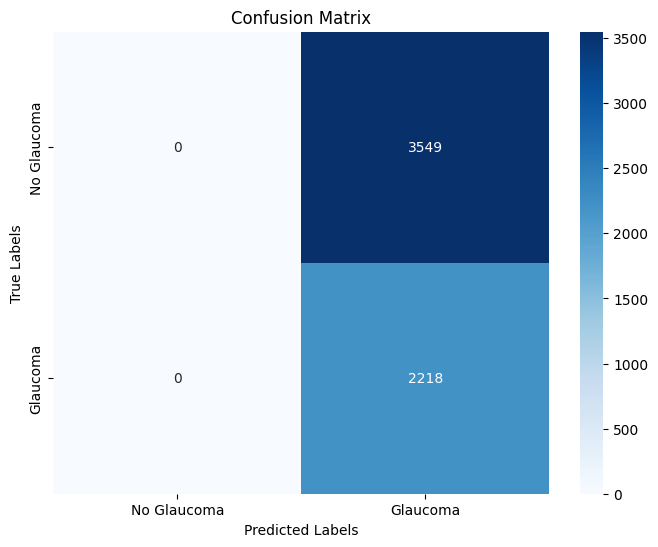

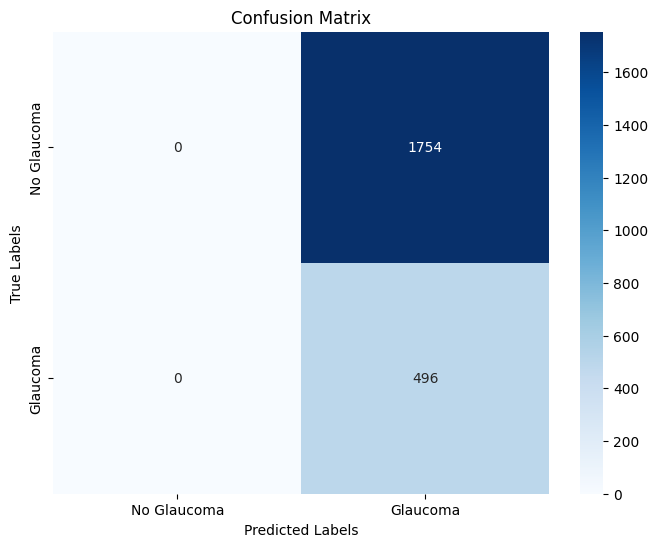

In [32]:
import seaborn as sns
# Función para dibujar la matriz de confusión
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    plt.show()

# Dibujar la matriz de confusión para validación
plot_confusion_matrix(val_conf_matrix, class_names=["No Glaucoma", "Glaucoma"])

# Dibujar la matriz de confusión para prueba
plot_confusion_matrix(test_conf_matrix, class_names=["No Glaucoma", "Glaucoma"])